In [39]:
%matplotlib inline

import pandas as pd
import numpy as np
from biopandas.pdb import PandasPdb as PandasPdb
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.plotly as py
import plotly.graph_objs as go

## Global Variables and PDB Loading ##
The block below represents the variables, which hold key dataframes, lists, and objects from BioPandas, that are needed throughout the whole code. It is kept as global because it is much easier to access instead of having to pass through each variable for every function.

In this block, the pdb file of the desired flavoprotein is loaded and created into dataframes. The dataframes will allow the code to look up the coordinates for individual atoms in the flavoprotein to find the distances. The dataframes will also allow the mapping of each atom's associated chemical type.

In [70]:
key_atoms = ['N1', 'C2', 'O2', 'N3', 'C4', 'O4', 'C4A', 'C4X', 'N5', 'C5A', 'C5X', 'C6', 'C7', 'C7M', 'C8', 'C8M', 'C9', 'C9A', 'N10', 'C10']
key_res = ['FMN', 'FAD']
ambiguous_atom = ['C4A', 'C4X', 'C5A', 'C5X']

#Choose flavoprotein and angstrom limit. Choose if loading a biological assembly.
flavoprotein = input("Please enter flavin molecule: ")
bioassembly = input("Please enter bioassembly number. Enter 0 if not needed: ")
angstrom_limit = float(input("Please enter desired angstrom limit: "))

#If 0 is entered, then read normal PDB file. If a number is given, then read the given biological assembly
if bioassembly == 0:
    ppdb = PandasPdb().read_pdb("/Users/davidkim/Documents/Senior/SI 485/pdb_file/%s.pdb" % flavoprotein)
else:
    ppdb = PandasPdb().read_pdb("/Users/davidkim/Documents/Senior/SI 485/pdb_file/%s.pdb" % flavoprotein + bioassembly)
    
#Create dataframes from chosen pdb file
df_atom = ppdb.df['ATOM']
df_hetatm = ppdb.df['HETATM']
df = pd.concat([df_atom, df_hetatm])
df = df.reset_index(drop=True)

#Dataframe of the codes for atom types
df_codes = pd.read_csv("code.csv")

#Dataframe of the chemical names of the codes
df_chemicals = pd.read_csv("code_labels.csv")

Please enter flavin molecule: 1pbe
Please enter bioassembly number. Enter 0 if not needed: 1
Please enter desired angstrom limit: 3.5


## Amiguous Atom Name Fix ##
In the PDB files, C4A and C4X, as well as C5A and C5X, the 'A' and 'X' label are interchangeable. However, the 'A' and 'X' atoms are not the same. The important one is in the isoalloxazine structure. This function is used to find the index number of N5, an atom in the isoalloxazine structure. By finding the index number for N5, the code can check to see if the 'A' or 'X' atom lies within the isoalloxazine structure by measuring the distance to the N5 atom. 

In [71]:
#Find index number of N5 to check which of the ambiguous atoms are isoalloxazines
def check_ambiguous_atoms():
    index_N5 = []
    for i in range(len(df_hetatm)): #Use df_hetatm instead of df because distance function reads only separated dataframe
        if df_hetatm.atom_name[i]== 'N5':
            index_N5.append(i)
        else:
            continue
    return(index_N5)

## Removing Irrelevant C1 Atom ##
The isoalloxazine structure is a set, predictable structure. The C1 atom, which is not part of the structure, is also always in the same position. Since the C1 position is already known, it is not needed when gathering distances of surrounding atom/heteroatoms. The purpose of this function is to find the index number of the C1 atom that is attached to the isoalloxazine structure in the dataframe to remove it later on.

In [64]:
#Find index number of C1 to exclude distant between isoalloxazine and C1 atom
def check_c1_atom():
    index_C1 = []
    for i in range(len(df_hetatm)): #Use df_hetatm instead of df because distance function reads only separated dataframe
        if df_hetatm.atom_name[i] == "C1'":
            index_C1.append(i)
        else:
            continue
    return(index_C1)

## Finding Distances ##
This function finds the distance between the surrounding heteroatoms/atoms and the isoalloxazine. This function takes in two dictionaries and the desired angstrom limit. It uses the Biopandas' distance function to quickly find the distances. This function returns two dictionaries containing the distances between isoalloxzine and atoms/heteroatoms.

In [72]:
def find_distance(distance_atom_dict, distance_het_dict, angstrom_limit):    
    i = 0
    for i in range(len(df)):
        if ((df.residue_name[i] in key_res) and (df.atom_name[i] in key_atoms)):
            reference_point = (df.x_coord[i], df.y_coord[i], df.z_coord[i])
            distances_atm = ppdb.distance(xyz=reference_point, records='ATOM')
            distances_het = ppdb.distance(xyz=reference_point, records='HETATM')
            for c1 in check_c1_atom(): #Checking to see if C1 atom is in isoalloxazine
                if (df.residue_number[i] == df_hetatm.residue_number[c1]):
                    distances_het = distances_het.drop(c1)
                else:
                    distances_het = distances_het
            if df.atom_name[i] in ambiguous_atom: #Checking to see which ambiguous atom is correct
                for ind in check_ambiguous_atoms():
                    if distances_het[ind] < 2.0: #If less than 2 Angstroms away, by recommendation of Bruce
                        distance_het_dict[i] = distances_het[distances_het <= angstrom_limit]
                        distance_atom_dict[i] = distances_atm[distances_atm <= angstrom_limit]
                        break
                    else:
                        continue
            else:
                distance_het_dict[i] = distances_het[distances_het <= angstrom_limit]
                distance_atom_dict[i] = distances_atm[distances_atm <= angstrom_limit]
                
    #Remove intra-isoalloxazine distances
    for k,v in distance_het_dict.items():
        for iso in v.index:
            if ((df_hetatm.atom_name[iso] in key_atoms) and (df_hetatm.residue_number[iso] == df.residue_number[k])):
                v = v.drop(iso)
        distance_het_dict[k] = v
        
    #This is to relabel the indices of distance_het_dict from df_hetatm indexes to the combined df indexes
    pairs = {}
    for k,v in distance_het_dict.items():
        lst = []
        if len(v.index) != 0:
            for targ in v.index:
                check_res_numb = df_hetatm.residue_number[targ]
                check_atom_name = df_hetatm.atom_name[targ]
                new_targ = df.index[(df.residue_number == check_res_numb) & (df.atom_name == check_atom_name)]
                lst.append((new_targ.values[0], v[targ]))
            pairs[k] = lst
    
    distance_het_dict = pairs
    
    return (distance_atom_dict, distance_het_dict)

## Create Dataframe ##
This function creates a dataframe of the distance relationship between each atom in the isoalloxazine and its
surrounding atoms and heteroatoms. It also finds the chemical code associated with the target atom/heteroatom. 

In [66]:
def distance_dataframe(distance_atom_dict, distance_het_dict):
    ref_atom_list = []
    target_atom_list = []
    distance_list = []

    for k,v in distance_atom_dict.items():
        for target, dist in v.iteritems():
            ref_atom_list.append(k)
            target_atom_list.append(target)
            distance_list.append(dist)

    for k,v in distance_het_dict.items():
        for i in v:
            ref_atom_list.append(k)
            target_atom_list.append(i[0])
            distance_list.append(i[1])

    df_dist = pd.DataFrame()
    df_dist['isoalloxazine'] = ref_atom_list
    df_dist['target_atom'] = target_atom_list
    df_dist['distance'] = distance_list
    
    #This is to find the associated chemical code of the target atom/heteroatm
    code_list = []
    for i in df_dist['target_atom']:
        temp = df_codes.index[(df_codes.Residue == df.residue_name[i]) & (df_codes.Atom == df.atom_name[i])]
        if len(temp) != 0:
            code_list.append(df_codes.Code[temp[0]])
        else:
            code_list.append(0) #Every atom is not represented in the code doc Dr. Palfey gave us. 0 for now.

    df_dist['chemical_codes'] = code_list
    
    #This is to find the associated chemical type of the target atom/heteroatm
    chemical_list = []
    for i in df_dist['chemical_codes']:
        temp = df_chemicals.index[df_chemicals.Code == i]
        try:
            chemical_list.append(df_chemicals.Label[temp[0]])
        except:
            chemical_list.append("N/A")
    
    df_dist['chemical_type'] = chemical_list
    
    return(df_dist)

## Graph Chemical Type Frequency ##
This functions produces bar graphs of the frequency of chemical types of the atoms surrounding eahc individual atom in the isoalloxazine.

In [67]:
def graph_atom_type_per_atom(plt, df_dist):
    check_key_atom = df.atom_name.isin(key_atoms)
    check_key_res = df.residue_name.isin(key_res)
    df_iso = df.loc[(check_key_atom & check_key_res)]
    for i in df_iso.index:
        try:
            df_dist[df_dist.isoalloxazine == i].chemical_type.value_counts().sort_index().plot(kind="bar", title=(df.residue_name[i] + str(df.residue_number[i]) + ":" + df.atom_name[i])).set(xlabel="Atom Type", ylabel="Count")
            plt.show()
        except:
            continue

In [68]:
def main():    
    #Create empty dictionaries for distances
    distance_atom_dict = {}
    distance_het_dict = {}
    
    #Call 'find_distance' function and set empty dictionaries equal to output of the function
    distances = find_distance(distance_atom_dict, distance_het_dict, angstrom_limit)
    distance_atom_dict = distances[0]
    distance_het_dict = distances[1]
    
    #Create a datagrame that holds the distances and chemical codes from the distance_dataframe function
    df_distance = distance_dataframe(distance_atom_dict, distance_het_dict)
    
    #Produces a bar graph of the count of the surrounding atom types
    df_distance.chemical_type.value_counts().sort_index().plot(kind="bar", title=flavoprotein).set(xlabel="Atom Type", ylabel="Count")
    plt.show()
    
    graph_atom_type_per_atom(plt, df_distance)

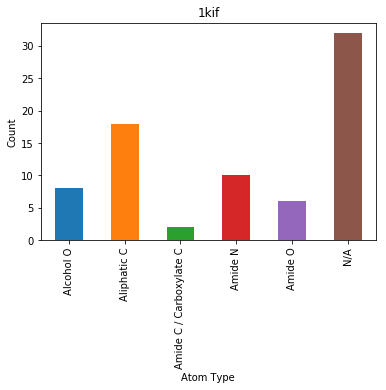

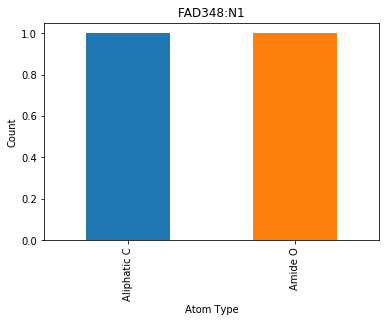

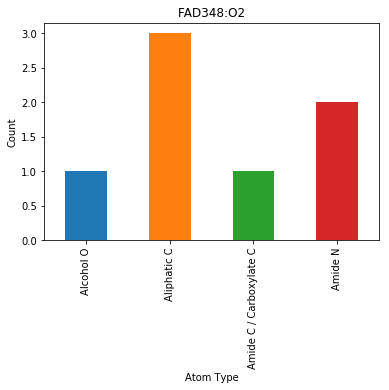

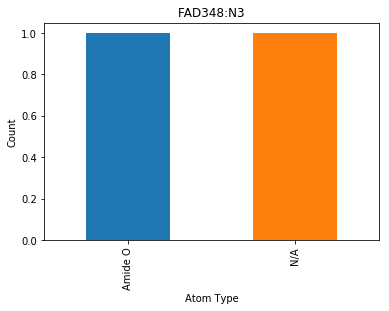

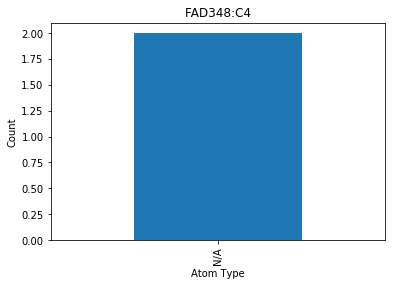

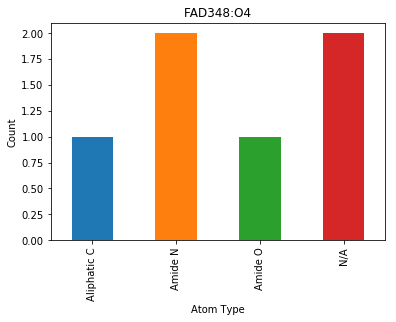

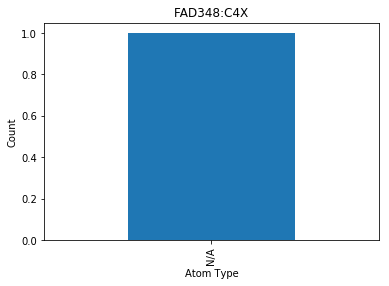

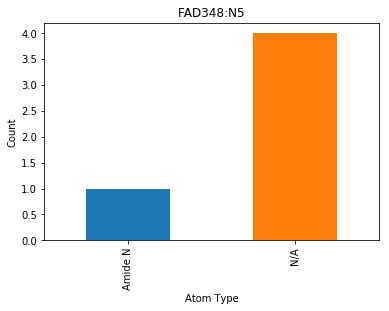

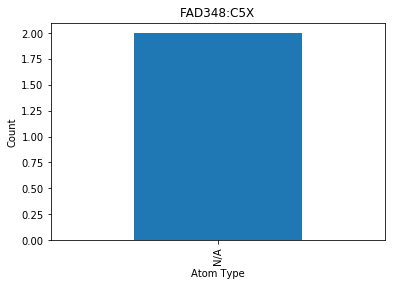

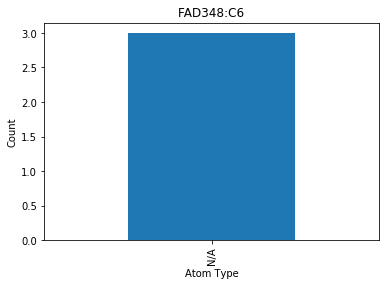

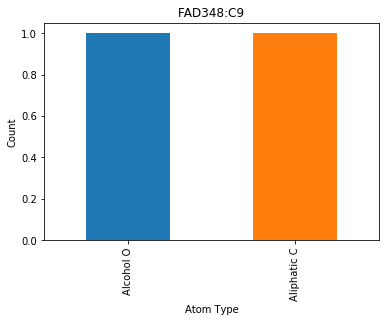

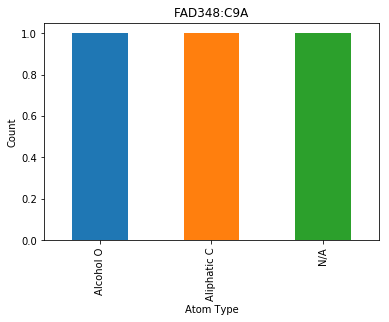

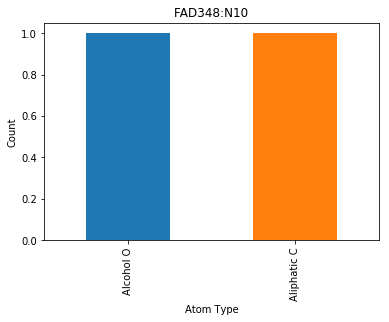

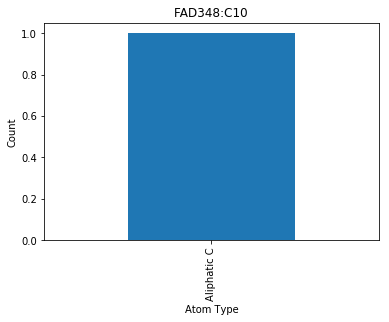

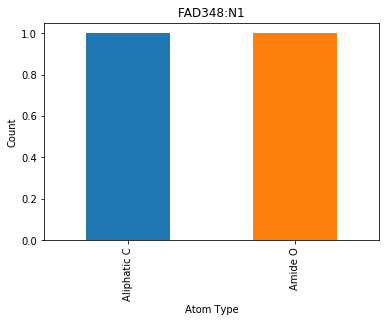

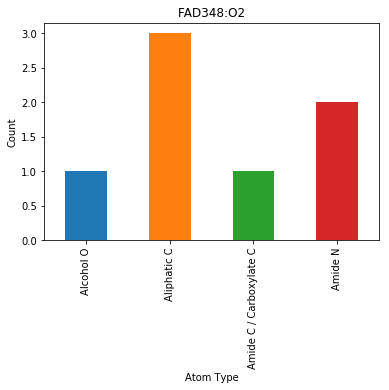

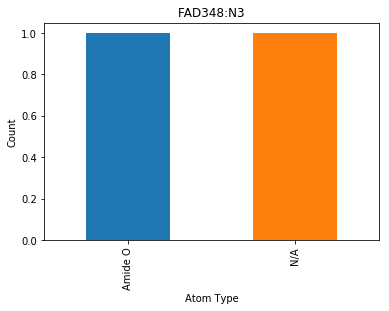

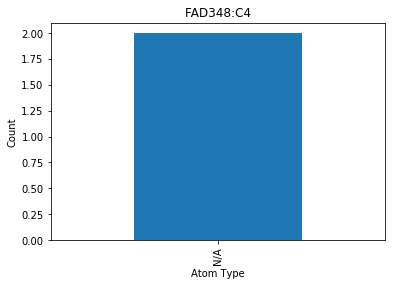

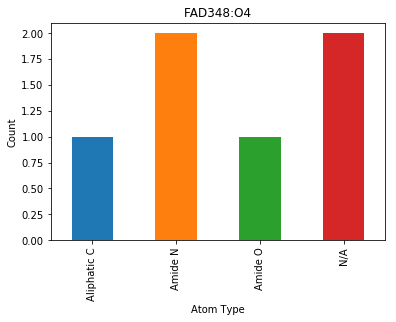

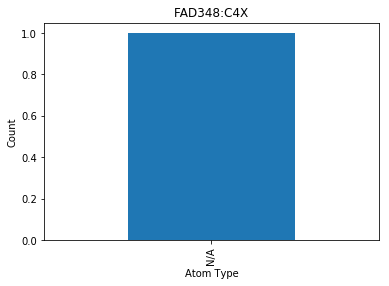

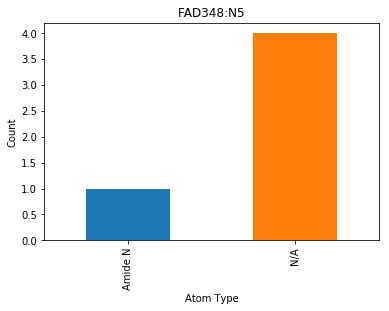

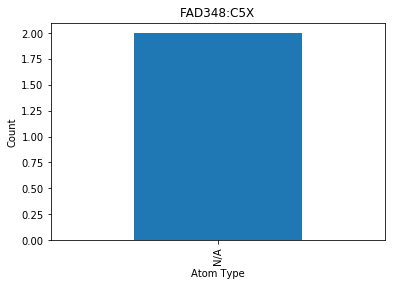

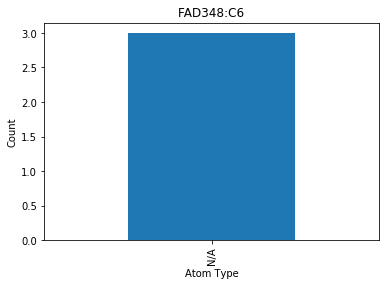

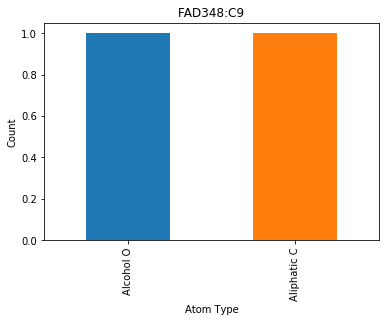

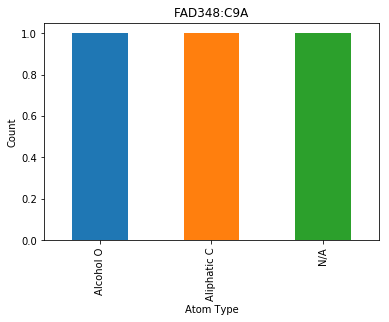

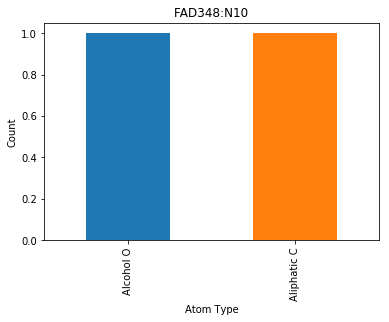

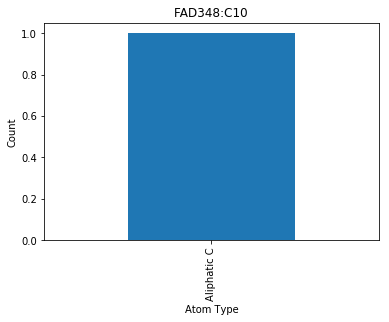

In [69]:
if __name__ == "__main__":
    main()